1
values: [array([0., 0.])]
value_matxs: [array([[0., 0.],
       [0., 0.]])]
2
values: [array([  5., -10.]), array([-1., -1.]), array([-20.,   5.])]
value_matxs: [array([[  5., -10.],
       [  5., -10.]]), array([[  5., -10.],
       [ -1.,  -1.]]), array([[  5., -10.],
       [-20.,   5.]]), array([[ -1.,  -1.],
       [  5., -10.]]), array([[-1., -1.],
       [-1., -1.]]), array([[ -1.,  -1.],
       [-20.,   5.]]), array([[-20.,   5.],
       [  5., -10.]]), array([[-20.,   5.],
       [ -1.,  -1.]]), array([[-20.,   5.],
       [-20.,   5.]])]
3
values: [array([  4.7625, -10.2375]), array([ 2.61 , -4.515]), array([-1.   , -0.525]), array([-5.56,  2.04]), array([-20.2375,   4.7625])]
value_matxs: [array([[  4.7625, -10.2375],
       [  4.7625, -10.2375]]), array([[  4.7625, -10.2375],
       [  2.61  ,  -4.515 ]]), array([[  4.7625, -10.2375],
       [ -1.    ,  -0.525 ]]), array([[  4.7625, -10.2375],
       [ -5.56  ,   2.04  ]]), array([[  4.7625, -10.2375],
       [-20.2375,  

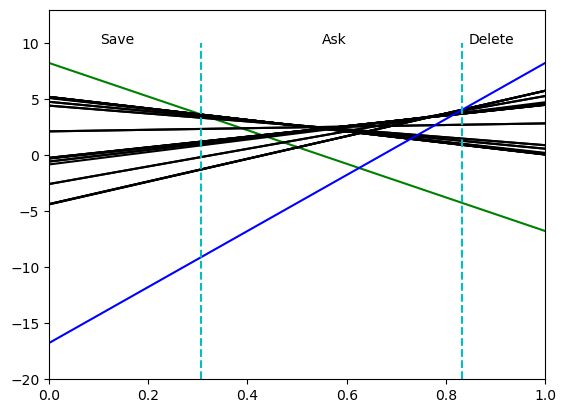

In [3]:
import random
from collections import defaultdict
import numpy as np
from utils import vector_add, orientations, turn_right, turn_left

class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states #or self.get_states_from_transitions(transitions)

        self.init = init #is just the initial value which we can also just make randomly

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions #or {}
        # if not self.transitions:
        #     print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward #or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state): #Reward Function
        """Return a numeric reward for this state."""

        return self.reward[state]
    
    #this one needs to be extended 

    def T(self, state, action): #Transition Function
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

#this is just if the states were not passed but we'll make sure they are always passed

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001



class POMDP(MDP):
    """A Partially Observable Markov Decision Process, defined by
    a transition model P(s'|s,a), actions A(s), a reward function R(s),
    and a sensor model P(e|s). We also keep track of a gamma value,
    for use by algorithms. The transition and the sensor models
    are defined as matrices. We also keep track of the possible states
    and actions for each state. [Page 659]."""

    def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95):
        """Initialize variables of the pomdp"""

        if not (0 < gamma <= 1):
            raise ValueError('A POMDP must have 0 < gamma <= 1')

        self.states = states
        self.actions = actions

        # transition model cannot be undefined
        self.t_prob = transitions or {}
        if not self.t_prob:
            print('Warning: Transition model is undefined')

        # sensor model cannot be undefined
        self.e_prob = evidences or {}
        if not self.e_prob:
            print('Warning: Sensor model is undefined')

        self.gamma = gamma
        self.rewards = rewards

    def remove_dominated_plans(self, input_values):
        """
        Remove dominated plans.
        This method finds all the lines contributing to the
        upper surface and removes those which don't.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = [values[0]]
        y1_max = max(val[1] for val in values)
        tgt = values[0]
        prev_b = 0
        prev_ix = 0
        while tgt[1] != y1_max:
            min_b = 1
            min_ix = 0
            for i in range(prev_ix + 1, len(values)):
                if values[i][0] - tgt[0] + tgt[1] - values[i][1] != 0:
                    trans_b = (values[i][0] - tgt[0]) / (values[i][0] - tgt[0] + tgt[1] - values[i][1])
                    if 0 <= trans_b <= 1 and trans_b > prev_b and trans_b < min_b:
                        min_b = trans_b
                        min_ix = i
            prev_b = min_b
            prev_ix = min_ix
            tgt = values[min_ix]
            best.append(tgt)

        return self.generate_mapping(best, input_values)

    def remove_dominated_plans_fast(self, input_values):
        """
        Remove dominated plans using approximations.
        Resamples the upper boundary at intervals of 100 and
        finds the maximum values at these points.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = []
        sr = 100
        for i in range(sr + 1):
            x = i / float(sr)
            maximum = (values[0][1] - values[0][0]) * x + values[0][0]
            tgt = values[0]
            for value in values:
                val = (value[1] - value[0]) * x + value[0]
                if val > maximum:
                    maximum = val
                    tgt = value

            if all(any(tgt != v) for v in best):
                best.append(np.array(tgt))

        return self.generate_mapping(best, input_values)

    def generate_mapping(self, best, input_values):
        """Generate mappings after removing dominated plans"""

        mapping = defaultdict(list)
        for value in best:
            for action in input_values:
                if any(all(value == v) for v in input_values[action]):
                    mapping[action].append(value)

        return mapping

    def max_difference(self, U1, U2):
        """Find maximum difference between two utility mappings"""

        for k, v in U1.items():
            sum1 = 0
            for element in U1[k]:
                sum1 += sum(element)
            sum2 = 0
            for element in U2[k]:
                sum2 += sum(element)
        return abs(sum1 - sum2)

#%%

class Matrix:
    """Matrix operations class"""

    @staticmethod
    def add(A, B):
        """Add two matrices A and B"""

        res = []
        for i in range(len(A)):
            row = []
            for j in range(len(A[0])):
                row.append(A[i][j] + B[i][j])
            res.append(row)
        return res

    @staticmethod
    def scalar_multiply(a, B):
        """Multiply scalar a to matrix B"""

        for i in range(len(B)):
            for j in range(len(B[0])):
                B[i][j] = a * B[i][j]
        return B

    @staticmethod
    def multiply(A, B):
        """Multiply two matrices A and B element-wise"""

        matrix = []
        for i in range(len(B)):
            row = []
            for j in range(len(B[0])):
                row.append(B[i][j] * A[j][i])
            matrix.append(row)

        return matrix

    @staticmethod
    def matmul(A, B):
        """Inner-product of two matrices"""

        return [[sum(ele_a * ele_b for ele_a, ele_b in zip(row_a, col_b)) for col_b in list(zip(*B))] for row_a in A]

    @staticmethod
    def transpose(A):
        """Transpose a matrix"""

        return [list(i) for i in zip(*A)]
    
def pomdp_value_iteration(pomdp, epsilon=0.1):
    """Solving a POMDP by value iteration."""

    U = {'':[[0]* len(pomdp.states)]}
    count = 0
    while True:
        count += 1
        prev_U = U
        values = [val for action in U for val in U[action]]
        value_matxs = []
        for i in values:
            for j in values:
                value_matxs.append([i, j])

        U1 = defaultdict(list)
        for action in pomdp.actions:
            for u in value_matxs:
                u1 = Matrix.matmul(Matrix.matmul(pomdp.t_prob[int(action)], Matrix.multiply(pomdp.e_prob[int(action)], Matrix.transpose(u))), [[1], [1]])
                u1 = Matrix.add(Matrix.scalar_multiply(pomdp.gamma, Matrix.transpose(u1)), [pomdp.rewards[int(action)]])
                U1[action].append(u1[0])

        U = pomdp.remove_dominated_plans_fast(U1)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations
        
        if count > 10:
            if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
                return U

def pomdp_value_iteration_numpy(pomdp, epsilon=0.1):
    """Solving a POMDP by value iteration."""

    U = {'': np.zeros((1, len(pomdp.states)))}
    count = 0
    while True:
        count += 1
        print(count)
        prev_U = U
        values = [val for action in U for val in U[action]]
        value_matxs = []
        for i in values:
            for j in values:
                value_matxs.append(np.array([i, j]))

        if count < 10:
            print(f"values: {values}")
            print(f"value_matxs: {value_matxs}")
        U1 = defaultdict(list)
        for action in pomdp.actions:
            for u in value_matxs:
                u1 = np.matmul(np.matmul(pomdp.t_prob[int(action)], np.multiply(pomdp.e_prob[int(action)], u.T)), np.array([[1], [1]]))
                u1 = np.add(np.multiply(pomdp.gamma, u1.T), [pomdp.rewards[int(action)]])
                U1[action].append(u1[0])

        U = pomdp.remove_dominated_plans_fast(U1)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations
        
        if count > 10:
            if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
                return U

# # Initial Conditions

# transition function P(s'|s,a)
t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]], [[1.0, 0.0], [0.0, 1.0]]]
# evidence function P(e|s)
e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]], [[0.8, 0.2], [0.3, 0.7]]] #here the evidence seems to already be predefined! How do we define it gradually? Or do I just predefine? 
# reward function
rewards = [[5, -10], [-20, 5], [-1, -1]]

gamma = 0.95
actions = ('0', '1', '2')
states = ('0', '1')

pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

utility = pomdp_value_iteration_numpy(pomdp, epsilon=0.1)

%matplotlib inline


from notebook import psource, pseudocode, plot_pomdp_utility
plot_pomdp_utility(utility)

In [2]:
print(len(utility['2']))
print(type(utility))
print(utility['2'])


29
<class 'collections.defaultdict'>
[array([5.21664959, 0.06321564]), array([5.21562333, 0.06534797]), array([5.20870481, 0.07858618]), array([5.20870012, 0.07859446]), array([5.20159306, 0.08984539]), array([5.15368087, 0.15969482]), array([5.15364835, 0.15973848]), array([5.1044305 , 0.21910232]), array([4.77262865, 0.58765229]), array([4.7724034 , 0.58788264]), array([4.43155958, 0.90110695]), array([4.43155906, 0.9011074 ]), array([2.13376285, 2.84570514]), array([2.13220294, 2.84692057]), array([-0.22821134,  4.49960125]), array([-0.22821491,  4.49960361]), array([-0.23361627,  4.50281012]), array([-0.27002954,  4.52271721]), array([-0.27005426,  4.52272965]), array([-0.30745982,  4.53964835]), array([-0.55962922,  4.64468509]), array([-0.55980042,  4.64475074]), array([-0.81884172,  4.73401967]), array([-2.56516723,  5.28823015]), array([-2.56635276,  5.28857655]), array([-4.36026762,  5.75959054]), array([-4.36027033,  5.75959122]), array([-4.36437537,  5.76050507]), array([-4.